In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"              # avoid DataParallel weirdness
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
import sys, torch
print("Python:", sys.executable)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
from dataclasses import dataclass
from typing import Any, Dict, List
from datasets import load_dataset
import torch
from transformers import (
    AutoProcessor, MllamaForConditionalGeneration,
    BitsAndBytesConfig, TrainingArguments
)
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
from PIL import Image
import pandas as pd
from pathlib import Path
import json, random
import argparse
from datasets import load_dataset
from transformers import AutoProcessor, MllamaForConditionalGeneration, BitsAndBytesConfig, TrainingArguments
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
from PIL import Image
import torch, os, re
from dataclasses import dataclass
import pandas as pd

Python: /home/hice1/wyiu31/scratch/venvs/llama32v/bin/python
Torch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA H100 80GB HBM3


/home/hice1/wyiu31/scratch/venvs/llama32v/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from transformers import MllamaForConditionalGeneration, AutoProcessor
from PIL import Image
import torch

# Use your local model copy
LOCAL_DIR = "/home/hice1/wyiu31/scratch/models/llama32v"
os.environ["TRANSFORMERS_OFFLINE"] = "1"

# Safer default on shared GPUs (auto offload if VRAM is tight)
model = MllamaForConditionalGeneration.from_pretrained(
    LOCAL_DIR, device_map="auto", dtype=torch.float16, local_files_only=True
)
processor = AutoProcessor.from_pretrained(LOCAL_DIR, local_files_only=True)
print("Model & processor loaded")

Loading checkpoint shards: 100%|██████████| 5/5 [00:31<00:00,  6.27s/it]


Model & processor loaded


In [3]:
# Sense Check 1
import json, re
from pathlib import Path

# Path to your observation file
path = Path("/home/hice1/wyiu31/scratch/stonemt_cameratrap/Camera Trap Photos/label_json/Observations_2022_with_images_v2.jsonl")

total, unknown = 0, 0

with path.open() as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        total += 1
        try:
            rec = json.loads(line)
            # Combine possible text fields (adjust these keys if your schema differs)
            text = json.dumps(rec)
            if re.search(r"\bUnknown\b", text, re.IGNORECASE):
                unknown += 1
        except json.JSONDecodeError:
            continue

print(f"Lines processed: {total}")
if total > 0:
    print(f"Unknown labels: {unknown}/{total} = {unknown/total:.1%}")
else:
    print("No valid lines found.")

Lines processed: 6273
Unknown labels: 0/6273 = 0.0%


In [4]:
# 0) Make a clean train/valid split that keeps only rows with images and strips the label to just the Common Name
import json, re, random
from pathlib import Path

SRC = Path("/home/hice1/wyiu31/scratch/stonemt_cameratrap/Camera Trap Photos/label_json/Observations_2022_with_images_v2.jsonl")
OUT = Path("/home/hice1/wyiu31/scratch/llama32v_ft/data/version_9"); OUT.mkdir(parents=True, exist_ok=True)

def just_common_name(s: str) -> str:
    m = re.search(r"Common Name:\s*(.+)$", s.strip())
    return m.group(1).strip() if m else s.strip()

records = []
with SRC.open() as f:
    for line in f:
        if not line.strip(): continue
        r = json.loads(line)
        imgs = r.get("images") or []
        if not imgs:           # require at least one image
            continue
        r["output"] = just_common_name(r.get("output",""))
        if not r["output"]:
            continue
        # keep only the FIRST image to simplify
        r["images"] = [imgs[0]]
        records.append(r)

# stratify by common name (lightweight)
by_cls = {}
for r in records:
    by_cls.setdefault(r["output"], []).append(r)

train, valid = [], []
for cls, items in by_cls.items():
    random.shuffle(items)
    k = max(1, int(0.1 * len(items)))      # 90/10 split
    valid += items[:k]
    train += items[k:]

def write_jsonl(p, rows):
    with open(p, "w") as f:
        for r in rows: f.write(json.dumps(r) + "\n")

write_jsonl(OUT/"train.jsonl", train)
write_jsonl(OUT/"valid.jsonl", valid)

print("Classes:", {k: len(v) for k,v in by_cls.items()})
print("Train:", len(train), "Valid:", len(valid))
print("Wrote:", OUT)

Classes: {'Eastern Gray Squirrel': 614, 'White-tailed Deer': 5207, 'Barred Owl': 27, 'Raccoon': 59, 'Virginia Opossum': 9, 'Northern Cardinal': 13, 'Unidentifiable': 55, 'Domestic Dog': 31, 'Downy Woodpecker': 3, 'Blue Jay': 11, 'American Robin': 20, 'Anole': 9, 'Long-tailed Weasel?': 3, 'Red-tailed Hawk': 6, 'Coyote': 88, 'Mourning Dove': 11, 'Lizard': 3, 'Eastern Chipmunk': 10, 'Eastern Wood Peewee': 3, 'Spider': 3, 'Bird': 28, 'Thrush': 3, 'Raptor': 3, 'Red-shouldered Hawk': 6, "Cooper's Hawk": 2, 'Northern Mockingbird': 4, 'Passerine': 6, 'Eastern Bluebird': 1, 'Southern Flying Squirrel': 5, 'Cricetidae': 2, 'Wild Boar': 6, 'Great Blue Heron': 22}
Train: 5641 Valid: 632
Wrote: /home/hice1/wyiu31/scratch/llama32v_ft/data/version_9


In [5]:
# Sense Check 3
import json, re
from pathlib import Path

# Path to your observation file
path = Path("/home/hice1/wyiu31/scratch/llama32v_ft/data/version_9/train.jsonl")

total, unknown = 0, 0

with path.open() as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        total += 1
        try:
            rec = json.loads(line)
            # Combine possible text fields (adjust these keys if your schema differs)
            text = json.dumps(rec)
            if re.search(r"\bUnknown\b", text, re.IGNORECASE):
                unknown += 1
        except json.JSONDecodeError:
            continue

print(f"Lines processed: {total}")
if total > 0:
    print(f"Unknown labels: {unknown}/{total} = {unknown/total:.1%}")
else:
    print("No valid lines found.")

Lines processed: 5641
Unknown labels: 0/5641 = 0.0%


In [6]:
# Sense Check 3
import json, re
from pathlib import Path

# Path to your observation file
path = Path("/home/hice1/wyiu31/scratch/llama32v_ft/data/version_9/valid.jsonl")

total, unknown = 0, 0

with path.open() as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        total += 1
        try:
            rec = json.loads(line)
            # Combine possible text fields (adjust these keys if your schema differs)
            text = json.dumps(rec)
            if re.search(r"\bUnknown\b", text, re.IGNORECASE):
                unknown += 1
        except json.JSONDecodeError:
            continue

print(f"Lines processed: {total}")
if total > 0:
    print(f"Unknown labels: {unknown}/{total} = {unknown/total:.1%}")
else:
    print("No valid lines found.")

Lines processed: 632
Unknown labels: 0/632 = 0.0%


[0] SM_1 | imgs=1 | Eastern Gray Squirrel


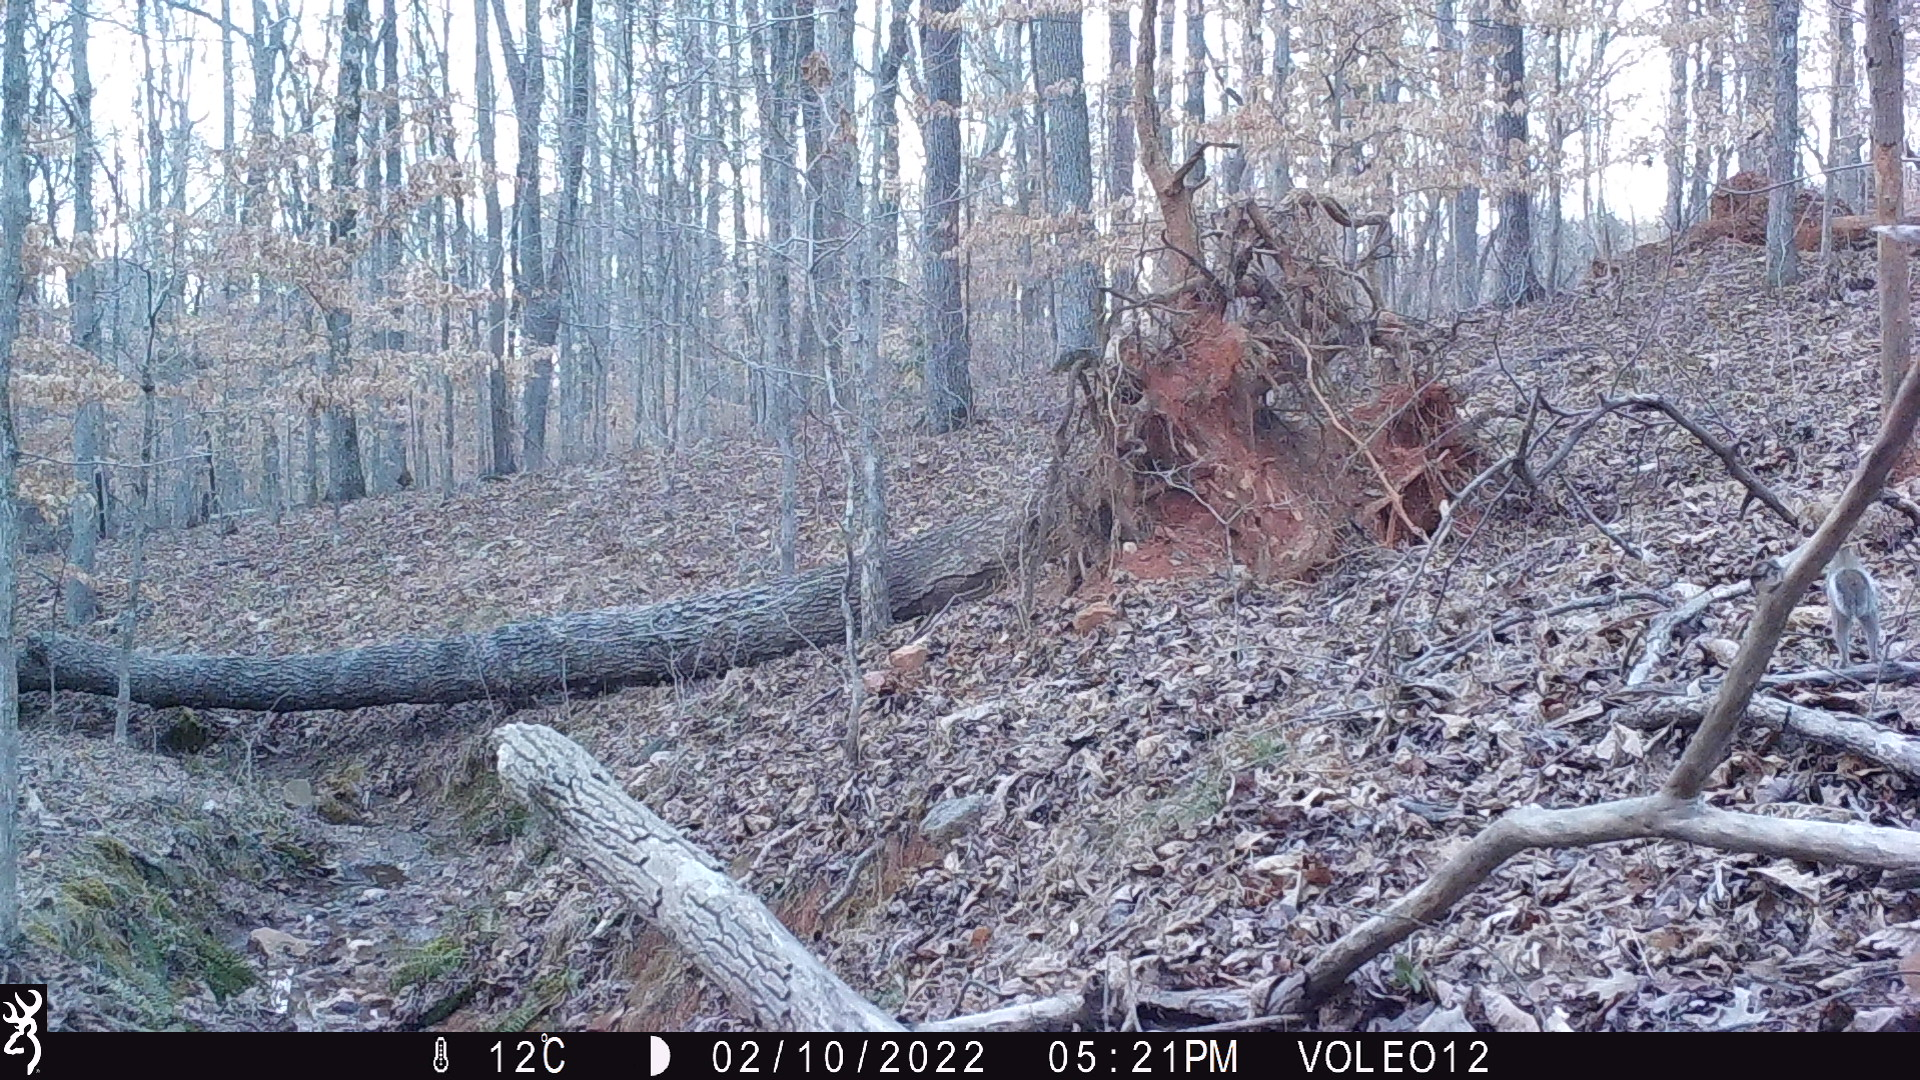

In [7]:
# 1a) Quick sanity check (preview a few JSONL samples + show images)

import json
from pathlib import Path
from IPython.display import Image, display

jsonl = Path("/home/hice1/wyiu31/scratch/stonemt_cameratrap/Camera Trap Photos/label_json/Observations_2022_with_images_v2.jsonl")

with jsonl.open() as f:
    for i, line in enumerate(f):
        rec = json.loads(line)
        print(f"[{i}] {rec['metadata']['location']} | imgs={len(rec['images'])} | {rec['output']}")
        for p in rec["images"][:4]:  # show up to 4 frames
            display(Image(filename=p))
        break  # show first record only

[0] SM_1 | imgs=1 | Eastern Gray Squirrel


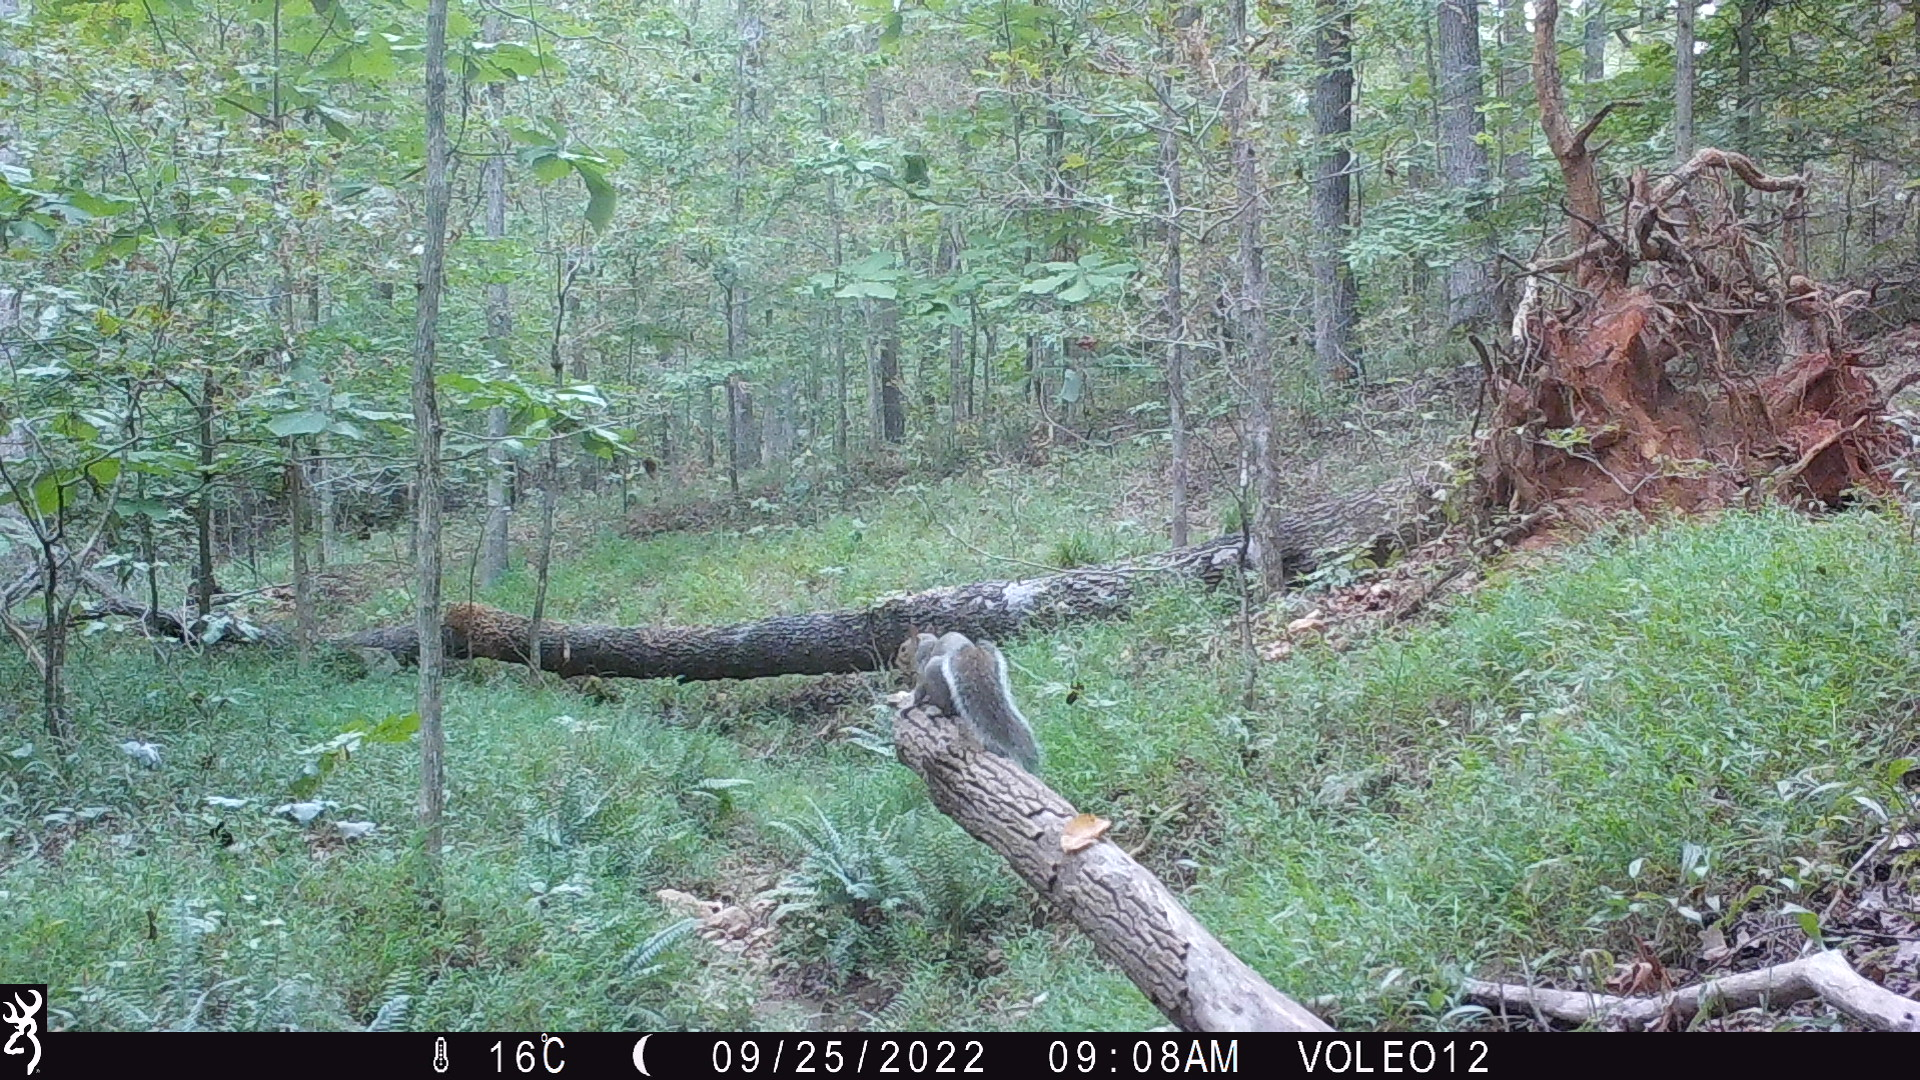

In [8]:
# 1b) Quick sanity check (preview a few JSONL samples + show images)

import json
from pathlib import Path
from IPython.display import Image, display

jsonl = Path("/home/hice1/wyiu31/scratch/llama32v_ft/data/version_9/train.jsonl")

with jsonl.open() as f:
    for i, line in enumerate(f):
        rec = json.loads(line)
        print(f"[{i}] {rec['metadata']['location']} | imgs={len(rec['images'])} | {rec['output']}")
        for p in rec["images"][:4]:  # show up to 4 frames
            display(Image(filename=p))
        break  # show first record only

[0] SM_1 | imgs=1 | Eastern Gray Squirrel


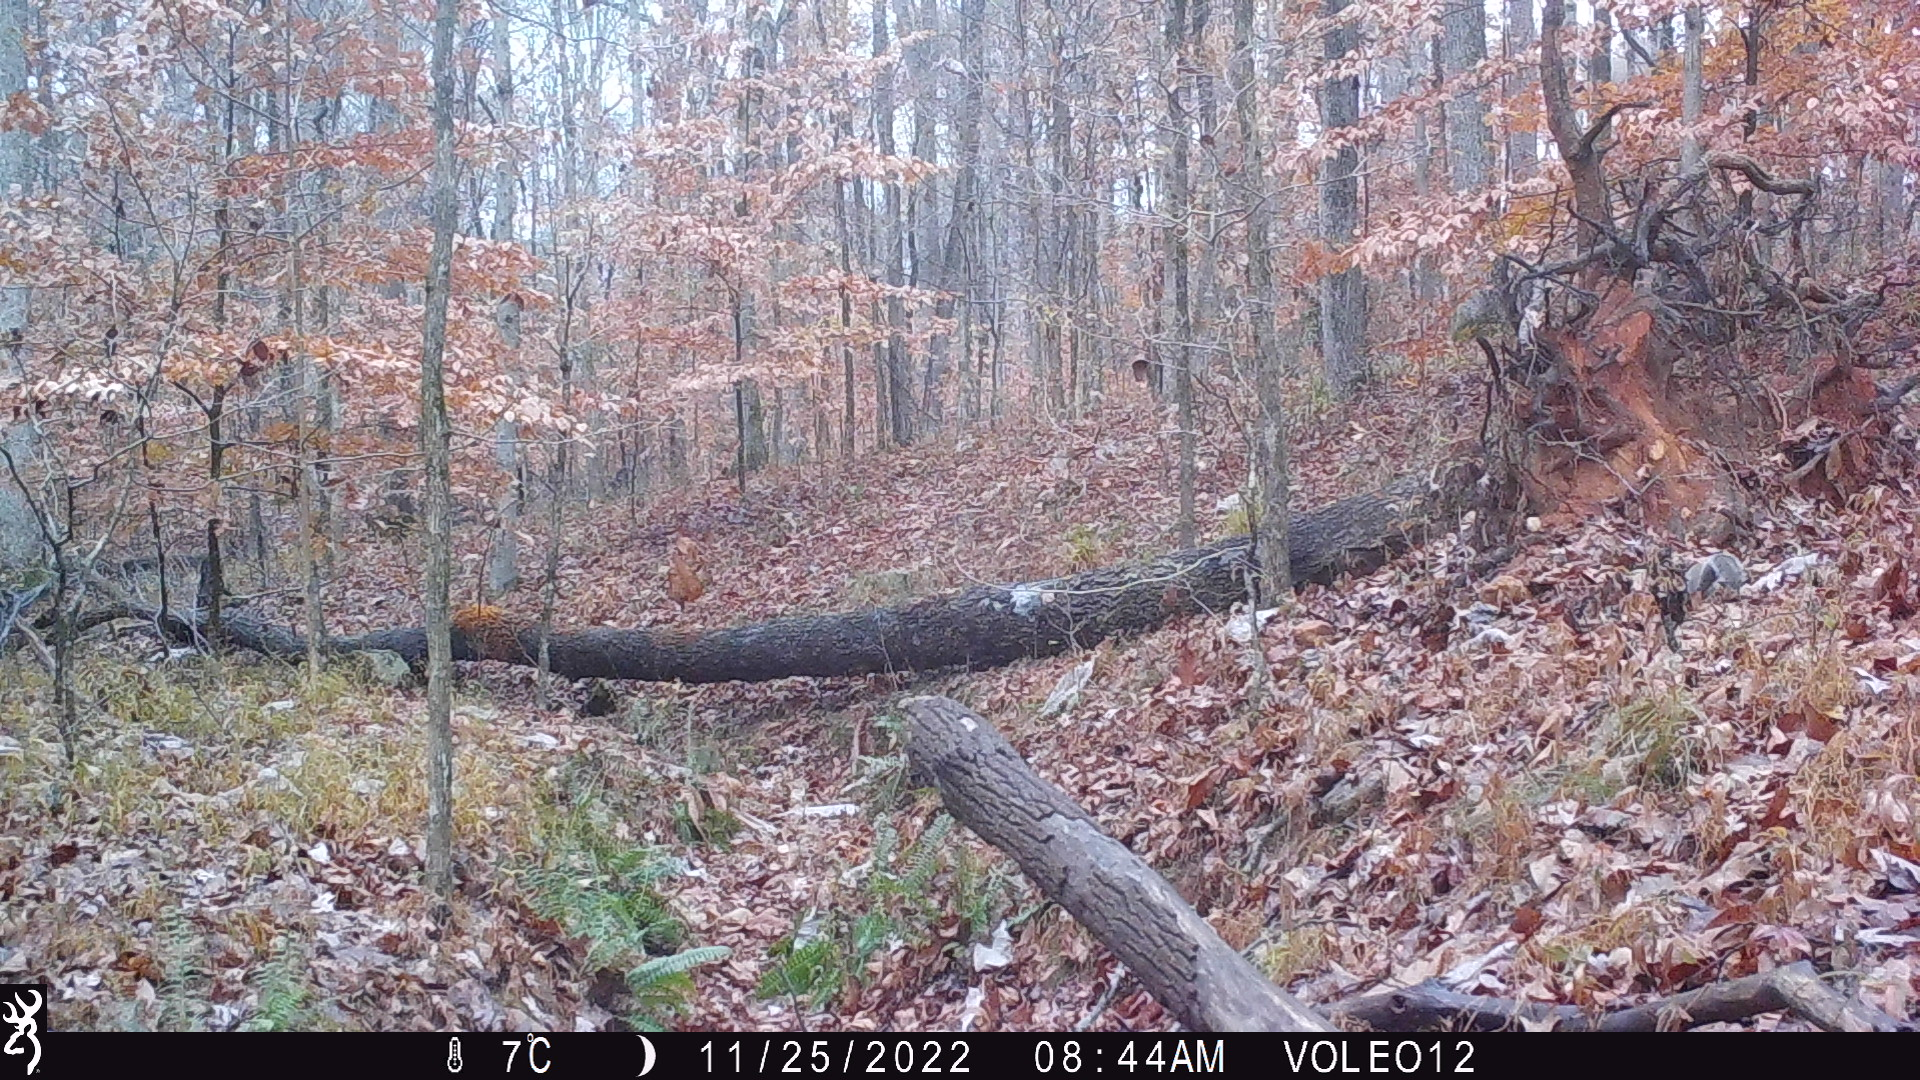

In [9]:
# 1c) Quick sanity check (preview a few JSONL samples + show images)

import json
from pathlib import Path
from IPython.display import Image, display

jsonl = Path("/home/hice1/wyiu31/scratch/llama32v_ft/data/version_9/valid.jsonl")

with jsonl.open() as f:
    for i, line in enumerate(f):
        rec = json.loads(line)
        print(f"[{i}] {rec['metadata']['location']} | imgs={len(rec['images'])} | {rec['output']}")
        for p in rec["images"][:4]:  # show up to 4 frames
            display(Image(filename=p))
        break  # show first record only

In [10]:
# 2) limit frames per sample and downscale images
MAX_FRAMES = 1
def _load_img_resized(path, max_side=512):
    img = Image.open(path).convert("RGB")
    w, h = img.size
    s = max_side / max(w, h)
    return img.resize((max(1,int(w*s)), max(1,int(h*s))))

import os, torch
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # precise error locations
torch.cuda.set_device(0)                  # you already set CUDA_VISIBLE_DEVICES=0
torch.cuda.empty_cache()

# --- add near the very top (after imports, before loading the model) ---
# Force non-reentrant checkpointing everywhere (PyTorch >=2.3)
try:
    from torch.utils.checkpoint import set_checkpoint_implementation
    set_checkpoint_implementation("no_reentrant")
except Exception:
    # Fallback for older PyTorch: monkey-patch checkpoint() to always be non-reentrant
    import torch.utils.checkpoint as _ckp
    _orig_ckpt = _ckp.checkpoint
    def _safe_ckpt(fn, *args, **kwargs):
        kwargs["use_reentrant"] = False
        return _orig_ckpt(fn, *args, **kwargs)
    _ckp.checkpoint = _safe_ckpt

In [14]:
# =========================
# VLM QLoRA + Focal Loss + Burst-aware multi-view
# + Motion-augmented foreground view (wind-robust)
# =========================
import os, re, gc, math, random, json, torch, torch.nn as nn
import numpy as np
import cv2  # if missing: pip install opencv-python-headless
from dataclasses import dataclass
from collections import Counter, defaultdict
from pathlib import Path
from datetime import datetime
from PIL import Image, ImageFilter
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoProcessor, MllamaForConditionalGeneration, BitsAndBytesConfig, TrainingArguments
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer

# ---------------- ENV / PERF ----------------
os.environ.setdefault("CUDA_VISIBLE_DEVICES", "0")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
os.environ.setdefault("TRANSFORMERS_OFFLINE", "1")
OFFLOAD_DIR = "/home/hice1/wyiu31/scratch/llama32v_ft/offload_cache"
os.makedirs(OFFLOAD_DIR, exist_ok=True)

torch.backends.cuda.matmul.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

# ---------------- DTYPE ----------------
use_bf16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
DTYPE = torch.bfloat16 if use_bf16 else torch.float16
torch.set_default_dtype(DTYPE)

# ---------------- PATHS ----------------
BASE = "/home/hice1/wyiu31/scratch/models/llama32v"
DATA = "/home/hice1/wyiu31/scratch/llama32v_ft/data/version_9"
OUT  = "/home/hice1/wyiu31/scratch/llama32v_ft/checkpoints/qlora/version_10_bursts_motion"

# ---------------- BURST PARAMS ----------------
BURST_WINDOW_SEC   = 90
MAX_IMGS_PER_BURST = 2            # keep small for memory (e.g. 1 raw + 1 masked)
VIEW_DROPOUT_RANGE = (1, MAX_IMGS_PER_BURST)
RANDOMIZE_VIEWS    = True

# ---------------- UTIL: clean CUDA before loading ----------------
def _fresh_cuda():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        try:
            torch.cuda.ipc_collect()
        except Exception:
            pass
    gc.collect()

_fresh_cuda()

# ---------------- QUANT CONFIG ----------------
bnb = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# ---------------- OOM-SAFE LOADER ----------------
def load_base_oom_safe():
    """
    Load base in 4-bit with a capped GPU budget and CPU/disk offload.
    If it fails (OOM), retry with eager attention.
    NOTE: keys in max_memory must be GPU indices (0,1,...) not "cuda:0".
    """
    gpu_idx = 0 if torch.cuda.is_available() else None
    max_mem = ({gpu_idx: "68GiB"} if gpu_idx is not None else {})
    max_mem["cpu"] = "120GiB"

    try:
        model = MllamaForConditionalGeneration.from_pretrained(
            BASE,
            quantization_config=bnb,
            device_map="auto",
            max_memory=max_mem,
            low_cpu_mem_usage=True,
            offload_state_dict=True,
            offload_folder=OFFLOAD_DIR,
            local_files_only=True,
        )
        model.config._attn_implementation = "sdpa"
        return model, False
    except RuntimeError:
        print("\n[loader] Auto device_map load failed (likely OOM). Retrying with eager attention…")
        _fresh_cuda()
        model = MllamaForConditionalGeneration.from_pretrained(
            BASE,
            quantization_config=bnb,
            device_map="auto",
            max_memory=max_mem,
            low_cpu_mem_usage=True,
            offload_state_dict=True,
            offload_folder=OFFLOAD_DIR,
            local_files_only=True,
        )
        model.config._attn_implementation = "eager"
        return model, True

# ---- load base & processor
model, used_eager = load_base_oom_safe()
processor = AutoProcessor.from_pretrained(BASE, local_files_only=True)

# Light dtype alignment
try:
    if hasattr(model, "model") and hasattr(model.model, "vision_tower"):
        model.model.vision_tower.to(dtype=DTYPE)
    if hasattr(model, "model") and hasattr(model.model, "mm_projector"):
        model.model.mm_projector.to(dtype=DTYPE)
except Exception:
    pass

# Defer token-embedding resize (smaller peak)
model.resize_token_embeddings(len(processor.tokenizer), mean_resizing=True)

# ---------------- K-BIT PREP + LORA (memory friendly) ----------------
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)
if hasattr(model, "gradient_checkpointing_enable"):
    model.gradient_checkpointing_enable()
model.enable_input_require_grads()
model.config.use_cache = False

peft_cfg = LoraConfig(
    r=8, lora_alpha=16,
    target_modules=["q_proj","k_proj","v_proj","o_proj"],
    lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)
model = get_peft_model(model, peft_cfg)

# Cast head input -> head weight dtype
class CastHeadInputToWeightDtype(nn.Module):
    def __init__(self, head):
        super().__init__()
        self.head = head
    def forward(self, x):
        return self.head(x.to(self.head.weight.dtype))

base_core = model.get_base_model()
base_core.lm_head = CastHeadInputToWeightDtype(base_core.lm_head)
model.lm_head = base_core.lm_head

# Trainable summary
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"\nAttention impl: {'eager' if used_eager else 'sdpa'}")
print(f"Trainable params: {trainable:,} / {total:,} ({100*trainable/total:.2f}%)")

# ---------------- HELPERS: labels / timestamps / bursts ----------------
TIMESTAMP_RE = re.compile(r"__(\d{8})_(\d{6})__")  # e.g. __20230920_030941__

def normalize_label(s: str) -> str:
    s = (s or "").strip().lower()
    s = re.sub(r"^common name[:\s]*", "", s)
    s = re.sub(r"[^a-z0-9\s\-']", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def parse_dt_from_path(p: str):
    m = TIMESTAMP_RE.search(p)
    if m:
        ymd, hms = m.group(1), m.group(2)
        try:
            return datetime.strptime(ymd + hms, "%Y%m%d%H%M%S")
        except Exception:
            return None
    return None

def burst_key_for_example(ex) -> tuple:
    md = ex.get("metadata") or {}
    loc = (md.get("location") or "").strip()
    imgs = ex.get("images") or []
    dt = parse_dt_from_path(imgs[0]) if imgs else None
    if dt is None:
        date_str = (md.get("date") or "").strip()
        time_str = (md.get("time") or "00:00:00").strip()
        try:
            dt = datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %H:%M:%S") if date_str else None
        except Exception:
            dt = None
    if dt is None:
        return (loc, "unknown", id(ex))
    bucket = int(dt.timestamp() // BURST_WINDOW_SEC)
    return (loc, dt.strftime("%Y-%m-%d"), bucket)

def merge_examples_into_bursts(examples, max_imgs=MAX_IMGS_PER_BURST):
    groups = defaultdict(list)
    for ex in examples:
        groups[burst_key_for_example(ex)].append(ex)

    merged = []
    for _, items in groups.items():
        # gather unique images
        seen, uniq = set(), []
        for ex in items:
            for p in (ex.get("images") or []):
                if isinstance(p, str) and p not in seen:
                    seen.add(p); uniq.append(p)
        if not uniq:
            continue

        # pick first non-empty label
        out = None
        for ex in items:
            s = ex.get("output")
            if isinstance(s, str) and s.strip():
                out = s.strip(); break
        if not out:
            continue

        md = items[0].get("metadata") or {}
        merged.append({
            "images": uniq[:max_imgs],
            "output": out,
            "metadata": {**md, "burst_size": len(uniq), "burst_group_count": len(items)}
        })
    return merged

# ---------------- LOAD + BURST MERGE + BALANCE ----------------
ds_raw = load_dataset(
    "json",
    data_files={"train": f"{DATA}/train.jsonl", "validation": f"{DATA}/valid.jsonl"},
)

def _ok_example(ex):
    return isinstance(ex.get("images"), list) and ex["images"] and isinstance(ex.get("output"), str) and ex["output"].strip()

train_ok = [ex for ex in ds_raw["train"] if _ok_example(ex)]
valid_ok = [ex for ex in ds_raw["validation"] if _ok_example(ex)]

train_bursts = merge_examples_into_bursts(train_ok, max_imgs=MAX_IMGS_PER_BURST)
valid_bursts = merge_examples_into_bursts(valid_ok, max_imgs=MAX_IMGS_PER_BURST)

print(f"After burst merge -> train bursts: {len(train_bursts)}  valid bursts: {len(valid_bursts)}")

class_counts = Counter(normalize_label(ex["output"]) for ex in train_bursts)
mean_cnt = sum(class_counts.values()) / max(1, len(class_counts))
alpha_map = {}
for k, c in class_counts.items():
    a = (mean_cnt / max(1, c)) ** 1.0
    alpha_map[k] = max(0.25, min(5.0, a))

UP = 1.2
target_len = int(len(train_bursts) * UP)
by_class = defaultdict(list)
for ex in train_bursts:
    by_class[normalize_label(ex["output"])].append(ex)
balanced = []
per_class_max = max(1, int(target_len / max(1, len(by_class))))
for k, items in by_class.items():
    need = max(len(items), min(per_class_max, len(items) * 3))
    if need <= len(items):
        balanced.extend(items)
    else:
        balanced.extend(items + random.choices(items, k=need - len(items)))
random.shuffle(balanced)
balanced = balanced[:target_len]

ds = DatasetDict({
    "train": Dataset.from_list(balanced),
    "validation": Dataset.from_list(valid_bursts)
})

print(f"After filter+burst+balance -> train: {len(train_ok)} imgs -> {len(train_bursts)} bursts -> {len(ds['train'])} balanced; valid: {len(ds['validation'])}")

# ---------------- MOTION-FOREGROUND UTILS (wind-robust) ----------------
def _to_gray_np(im: Image.Image):
    return np.array(im.convert("L"))

def _normalize01(x):
    x = x.astype(np.float32)
    x -= x.min()
    denom = (x.max() - x.min() + 1e-6)
    return x / denom

def _largest_component(mask, min_area=500):
    num, lab = cv2.connectedComponents(mask)
    if num <= 1:
        return mask
    areas = [(lab == i).sum() for i in range(1, num)]
    idx = np.argmax(areas) + 1
    out = np.zeros_like(mask)
    if areas[idx-1] >= min_area:
        out[lab == idx] = 255
    return out

def build_burst_foreground_mask(pil_imgs, flow_thresh=1.5, otsu_blur=9, morph_kernel=5,
                                min_area=800, require_persistence=True):
    """
    Return a soft mask [0..1] for the *first* frame, combining median background subtraction,
    optical flow vs next frame, and edge support. Designed to reduce wind false positives.
    """
    if len(pil_imgs) == 0:
        return None

    # median background over up to 5 frames
    frames = pil_imgs[:min(5, len(pil_imgs))]
    stack = np.stack([_to_gray_np(im) for im in frames], axis=0)
    bg = np.median(stack, axis=0).astype(np.uint8)

    first = _to_gray_np(pil_imgs[0])
    diff = cv2.absdiff(first, bg)
    diff = cv2.GaussianBlur(diff, (otsu_blur, otsu_blur), 0)
    _, fg1 = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # optical flow magnitude (first->second)
    if len(pil_imgs) >= 2:
        second = _to_gray_np(pil_imgs[1])
        flow = cv2.calcOpticalFlowFarneback(first, second, None,
                                            pyr_scale=0.5, levels=3,
                                            winsize=25, iterations=3,
                                            poly_n=5, poly_sigma=1.2, flags=0)
        mag = np.sqrt(flow[...,0]**2 + flow[...,1]**2)
        flow_mask = (mag > flow_thresh).astype(np.uint8) * 255
    else:
        flow_mask = np.zeros_like(fg1)

    # edge support
    edges = cv2.Canny(first, 50, 150)
    edges = cv2.dilate(edges, np.ones((3,3), np.uint8), iterations=1)
    edges = (edges > 0).astype(np.uint8) * 255

    comb = cv2.bitwise_and(fg1, cv2.bitwise_or(flow_mask, edges))

    # morphology cleanup + largest component
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel, morph_kernel))
    comb = cv2.morphologyEx(comb, cv2.MORPH_OPEN, k)
    comb = cv2.morphologyEx(comb, cv2.MORPH_CLOSE, k)
    comb = _largest_component(comb, min_area=min_area)

    # temporal persistence (intersection with second FG)
    if require_persistence and len(pil_imgs) >= 2:
        second = _to_gray_np(pil_imgs[1])
        diff2 = cv2.absdiff(second, bg)
        diff2 = cv2.GaussianBlur(diff2, (otsu_blur, otsu_blur), 0)
        _, fg2 = cv2.threshold(diff2, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel, morph_kernel))
        fg2 = cv2.morphologyEx(fg2, cv2.MORPH_OPEN, k2)
        fg2 = cv2.morphologyEx(fg2, cv2.MORPH_CLOSE, k2)
        comb = cv2.bitwise_and(comb, fg2)

    soft = _normalize01(comb)
    return soft  # float32 [0..1]

def apply_soft_mask(pil_img: Image.Image, soft_mask: np.ndarray, mode="gray", bg_strength=0.7):
    """
    Build a foreground-focused view:
      - mode='gray': desaturate & darken background
      - mode='blur': blur background
    """
    img = pil_img.convert("RGB")
    H, W = soft_mask.shape
    if (img.width, img.height) != (W, H):
        img = img.resize((W, H), Image.BICUBIC)

    if mode == "gray":
        gray = Image.fromarray(_to_gray_np(img)).convert("RGB")
        bg = Image.blend(gray, img, alpha=1 - bg_strength)  # darker/desaturated
    else:
        bg = img.filter(ImageFilter.GaussianBlur(radius=8))

    fg = img
    a = np.clip(soft_mask[..., None], 0, 1)  # H,W,1
    bg_np = np.array(bg, dtype=np.float32)
    fg_np = np.array(fg, dtype=np.float32)
    out = (a * fg_np + (1 - a) * bg_np).astype(np.uint8)
    return Image.fromarray(out)

# ---------------- COLLATOR (stochastic multi-view + motion-masked view) ----------------
@dataclass
class Collator:
    processor: any
    alpha_map: dict
    cache_size: int = 256
    def __post_init__(self):
        self._img_cache = {}
        self._keys = []
        tok = self.processor.tokenizer
        eid = tok.convert_tokens_to_ids("<|eot_id|>")
        self.eot_id = eid if isinstance(eid, int) and eid >= 0 else tok.eos_token_id

    def _open_cached(self, path):
        if path in self._img_cache:
            return self._img_cache[path]
        img = Image.open(path).convert("RGB")
        self._img_cache[path] = img
        self._keys.append(path)
        if len(self._keys) > self.cache_size:
            old = self._keys.pop(0)
            self._img_cache.pop(old, None)
        return img

    def __call__(self, batch):
        msgs, alphas, bad = [], [], 0
        for ex in batch:
            paths = list(ex.get("images") or [])
            if not paths:
                bad += 1
                continue
            if RANDOMIZE_VIEWS:
                random.shuffle(paths)
            # choose K raw views
            k = max(1, min(len(paths), random.randint(*VIEW_DROPOUT_RANGE)))
            picked = paths[:k]

            ans_raw = ex.get("output", "")
            ans_norm = normalize_label(ans_raw)
            if not ans_norm:
                bad += 1
                continue
            alpha = self.alpha_map.get(ans_norm, 1.0)

            # Load PILs once
            pil_imgs = []
            for p in picked:
                try:
                    pil_imgs.append(self._open_cached(p))
                except Exception:
                    pass
            if not pil_imgs:
                bad += 1
                continue

            # Build user content: raw views first
            user_content = [{"type": "image", "image": im} for im in pil_imgs[:MAX_IMGS_PER_BURST]]

            # Add ONE masked view if we have budget left
            if len(user_content) < MAX_IMGS_PER_BURST and len(pil_imgs) >= 1:
                try:
                    soft = build_burst_foreground_mask(pil_imgs)
                    if soft is not None and float(soft.max()) > 0.1:
                        masked = apply_soft_mask(pil_imgs[0], soft, mode="gray", bg_strength=0.7)
                        user_content.append({"type": "image", "image": masked})
                except Exception:
                    pass

            if not user_content:
                bad += 1
                continue

            user_content.append({"type": "text", "text": "Identify the species; please give the common name."})

            msgs.append([
                {"role": "user", "content": user_content},
                {"role": "assistant", "content": [{"type": "text", "text": ans_raw.strip()}]},
            ])
            alphas.append(alpha)

        if not msgs:
            raise ValueError(f"All samples invalid (bad={bad})")

        enc = self.processor.apply_chat_template(
            msgs, add_generation_prompt=False, tokenize=True,
            return_tensors="pt", return_dict=True, padding=True, truncation=True
        )
        enc.pop("cross_attention_mask", None)
        enc.pop("attention_mask_2d", None)

        if "pixel_values" in enc and enc["pixel_values"] is not None:
            enc["pixel_values"] = enc["pixel_values"].to(DTYPE)

        # answer-only labels between first two <|eot_id|>
        input_ids = enc["input_ids"]
        B, _ = input_ids.shape
        labels = torch.full_like(input_ids, -100, dtype=torch.long)
        answer_mask = torch.zeros_like(input_ids, dtype=torch.bool)
        for i in range(B):
            ids = input_ids[i]
            eots = (ids == self.eot_id).nonzero(as_tuple=True)[0]
            if len(eots) < 2:
                raise RuntimeError("Expected one user and one assistant turn.")
            s, e = int(eots[0]) + 1, int(eots[1])
            if e <= s:
                raise RuntimeError("Empty assistant span.")
            labels[i, s:e] = ids[s:e]
            answer_mask[i, s:e] = True

        enc["labels"] = labels
        enc["answer_mask"] = answer_mask
        enc["alpha"] = torch.tensor(alphas, dtype=torch.float32)
        return enc

collator = Collator(processor=processor, alpha_map=alpha_map)

if processor.tokenizer.pad_token is None:
    processor.tokenizer.pad_token = processor.tokenizer.eos_token

# ---------------- FOCAL TRAINER ----------------
FOCAL_GAMMA = 2.0

class FocalSFTTrainer(SFTTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        answer_mask = inputs.pop("answer_mask")
        alpha_vec = inputs.pop("alpha", None)

        outputs = model(**inputs, labels=None, return_dict=True)
        logits = outputs.logits
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()
        shift_mask   = answer_mask[:, 1:].contiguous()

        V = shift_logits.size(-1)
        ce = nn.functional.cross_entropy(
            shift_logits.view(-1, V),
            shift_labels.view(-1),
            reduction="none",
            ignore_index=-100,
        ).view_as(shift_labels)

        with torch.no_grad():
            logp = torch.log_softmax(shift_logits, dim=-1)
            true_logp = logp.gather(-1, shift_labels.clamp_min(0).unsqueeze(-1)).squeeze(-1)
            pt = true_logp.exp().clamp_(1e-6, 1 - 1e-6)
        loss_tok = ce * (1.0 - pt) ** FOCAL_GAMMA

        mask = (shift_labels != -100) & shift_mask
        loss_tok = loss_tok * mask.float()
        tok_count = mask.float().sum(dim=1) + 1e-6
        loss_per_sample = loss_tok.sum(dim=1) / tok_count

        if alpha_vec is not None:
            alpha_vec = alpha_vec.to(loss_per_sample.device)
            loss_per_sample = loss_per_sample * alpha_vec

        loss = loss_per_sample.mean()
        return (loss, outputs) if return_outputs else loss

# ---------------- TRAIN ARGS ----------------
args = TrainingArguments(
    output_dir=OUT,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    learning_rate=3e-4,
    num_train_epochs=1,
    lr_scheduler_type="cosine",
    bf16=use_bf16,
    fp16=not use_bf16,
    logging_steps=100,
    save_strategy="epoch",
    save_total_limit=2,
    report_to=[],
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    dataloader_drop_last=True,
    optim="adamw_torch_fused",
    group_by_length=False,
    remove_unused_columns=False,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
)

# ---------------- TRAIN ----------------
trainer = FocalSFTTrainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    data_collator=collator,
)

print("DTYPE:", DTYPE)
print("embed:", model.get_input_embeddings().weight.dtype)
lm = model.get_output_embeddings()
lm_w = lm.weight if hasattr(lm, "weight") else lm.head.weight
print("lm_head:", lm_w.dtype)

trainer.train()
trainer.save_model(OUT)

# End-of-training eval (loss only; accuracy is generation-time)
final_metrics = trainer.evaluate(ds["validation"])
print(final_metrics)

Loading checkpoint shards: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]



Attention impl: sdpa
Trainable params: 11,796,480 / 5,910,971,939 (0.20%)


Generating train split: 5641 examples [00:00, 11107.33 examples/s]
Generating validation split: 632 examples [00:00, 146146.22 examples/s]


After burst merge -> train bursts: 1492  valid bursts: 521
After filter+burst+balance -> train: 5641 imgs -> 1492 bursts -> 1754 balanced; valid: 521


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'bos_token_id': 128000, 'pad_token_id': 128004}.


DTYPE: torch.bfloat16
embed: torch.bfloat16
lm_head: torch.bfloat16


{'eval_loss': 0.1529441475868225, 'eval_runtime': 157.3453, 'eval_samples_per_second': 3.311, 'eval_steps_per_second': 0.419, 'epoch': 1.0}


In [16]:
# =========================
# burst_eval_scoring_multilabel.py
# Burst-aware validation with candidate scoring (no free generation)
# Multi-label aware: a burst is correct if pred ∈ gold_set
# =========================
import os, re, json, math, csv, torch
from collections import defaultdict, Counter
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Any
from PIL import Image
from tqdm import tqdm

from transformers import AutoProcessor, MllamaForConditionalGeneration, BitsAndBytesConfig
from peft import PeftModel

# ---- Paths (edit if needed) ----
BASE = "/home/hice1/wyiu31/scratch/models/llama32v"
CKPT = "/home/hice1/wyiu31/scratch/llama32v_ft/checkpoints/qlora/version_10_bursts_motion"
TRAIN_JSONL = "/home/hice1/wyiu31/scratch/llama32v_ft/data/version_9/train.jsonl"
VALID_JSONL = "/home/hice1/wyiu31/scratch/llama32v_ft/data/version_9/valid.jsonl"
CSV_OUT = "/home/hice1/wyiu31/scratch/llama32v_ft/val_burst_predictions_scoring_multilabel_v10.csv"

# ---- Eval & burst params ----
PROMPT = "Identify the species; please give the common name."
BURST_WINDOW_SEC   = 90
MAX_IMGS_PER_BURST = 4
SAVE_CSV           = True

# Optional: if True, drop bursts that contain >1 distinct labels in gold_set
DROP_MULTI_LABEL_BURSTS = False

# Speed/accuracy tradeoff: number of images to use per burst at eval (<= MAX_IMGS_PER_BURST)
EVAL_IMGS_PER_BURST = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ.setdefault("TRANSFORMERS_OFFLINE", "1")

TIMESTAMP_RE = re.compile(r"__(\d{8})_(\d{6})__")

# modest open-world bird expansion (only used if missing in your data)
BIRD_EXPANSION = [
    "Canada Goose", "Goose", "Snow Goose",
    "Mallard", "American Black Duck", "Wood Duck",
    "Ring-billed Gull", "Herring Gull",
    "Great Blue Heron", "Great Egret",
    "Mourning Dove", "Rock Pigeon",
    "Red-tailed Hawk", "Red-shouldered Hawk", "Barred Owl"
]

# ---------------- utils ----------------
def norm_label(s: str) -> str:
    s = (s or "").strip()
    s = re.sub(r"^common name[:\s]*", "", s, flags=re.I)
    s = re.sub(r"[^a-z0-9\s\-?']", "", s.lower())
    s = re.sub(r"\s+", " ", s).strip()
    return s

def ok_example(ex: Dict[str, Any]) -> bool:
    return (
        isinstance(ex.get("images"), list) and ex["images"] and
        isinstance(ex.get("output"), str) and ex["output"].strip()
    )

def parse_dt_from_path(p: str):
    m = TIMESTAMP_RE.search(p)
    if not m: return None
    try:
        return datetime.strptime(m.group(1)+m.group(2), "%Y%m%d%H%M%S")
    except Exception:
        return None

def burst_key(ex: Dict[str, Any]) -> tuple:
    md = ex.get("metadata") or {}
    loc = (md.get("location") or "").strip()

    dt = None
    imgs = ex.get("images") or []
    if imgs: dt = parse_dt_from_path(imgs[0])
    if dt is None:
        date_str = (md.get("date") or "").strip()
        time_str = (md.get("time") or "00:00:00").strip()
        try:
            if date_str and time_str:
                dt = datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %H:%M:%S")
            elif date_str:
                dt = datetime.strptime(date_str, "%Y-%m-%d")
        except Exception:
            dt = None

    if dt is None:
        return (loc, "unknown", id(ex))

    bucket = int(dt.timestamp() // BURST_WINDOW_SEC)
    day = dt.strftime("%Y-%m-%d")
    return (loc, day, bucket)

def merge_to_bursts(examples: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Multi-label aware:
      - Keep ALL labels from all members of a burst in metadata.gold_set (normalized)
      - Keep counts in metadata.gold_counts
      - Keep 'output' as a representative label (first raw label) only for display
    """
    groups = defaultdict(list)
    for ex in examples:
        groups[burst_key(ex)].append(ex)

    merged = []
    for _, items in groups.items():
        seen = set()
        imgs = []
        labels_raw = []
        for ex in items:
            for p in (ex.get("images") or []):
                if isinstance(p, str) and p not in seen:
                    imgs.append(p); seen.add(p)
            out = ex.get("output")
            if isinstance(out, str) and out.strip():
                labels_raw.append(out.strip())

        if not imgs or not labels_raw:
            continue

        gold_counts = Counter(norm_label(x) for x in labels_raw if norm_label(x))
        gold_set = sorted(k for k in gold_counts.keys() if k)

        # representative raw label for readability (not used for correctness)
        rep_raw = labels_raw[0]

        md0 = items[0].get("metadata") or {}
        merged.append({
            "images": imgs[:MAX_IMGS_PER_BURST],
            "output": rep_raw,
            "metadata": {
                **md0,
                "burst_size": len(imgs),
                "burst_group_count": len(items),
                "gold_set": gold_set,
                "gold_counts": dict(gold_counts),
            },
        })
    return merged

def load_candidates(*jsonls) -> List[str]:
    cnt = Counter()
    raw_map = {}
    for p in jsonls:
        if not os.path.exists(p): continue
        with open(p) as f:
            for line in f:
                try:
                    ex = json.loads(line)
                except Exception:
                    continue
                out = ex.get("output", "")
                if not isinstance(out, str) or not out.strip(): continue
                raw = out.strip()
                nn = norm_label(raw)
                if not nn: continue
                cnt[nn] += 1
                raw_map.setdefault(nn, raw)
    labels = [raw_map[nn] for nn,_ in cnt.items()]
    # add a few common birds if missing (safe)
    have_norm = {norm_label(x) for x in labels}
    for bird in BIRD_EXPANSION:
        if norm_label(bird) not in have_norm:
            labels.append(bird)
    return sorted(set(labels))

# ---------------- model I/O ----------------
def load_model_and_processor():
    processor = AutoProcessor.from_pretrained(BASE, local_files_only=True)
    tok = processor.tokenizer
    if tok.pad_token_id is None and tok.eos_token_id is not None:
        tok.pad_token = tok.eos_token

    bnb = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4",
                             bnb_4bit_compute_dtype=torch.float16)
    base = MllamaForConditionalGeneration.from_pretrained(
        BASE,
        quantization_config=bnb,
        device_map={"": 0} if device == "cuda" else None,
        local_files_only=True,
    )
    try:
        base.config._attn_implementation = "sdpa"
    except Exception:
        pass

    try:
        model = PeftModel.from_pretrained(base, CKPT, is_trainable=False)
    except Exception:
        model = MllamaForConditionalGeneration.from_pretrained(
            CKPT, device_map={"": 0} if device=="cuda" else None, local_files_only=True
        )

    model.eval(); model.config.use_cache = True
    if hasattr(model, "gradient_checkpointing_disable"):
        model.gradient_checkpointing_disable()
    return model, processor

def build_enc(processor, imgs: List[Image.Image]):
    msgs = [{
        "role": "user",
        "content": [*({"type":"image","image":im} for im in imgs),
                    {"type":"text","text": PROMPT}],
    }]
    txt = processor.apply_chat_template(
        msgs, add_generation_prompt=True, tokenize=True,
        return_tensors="pt", return_dict=True, padding=False, truncation=True
    )
    vis = processor(images=imgs, return_tensors="pt")
    enc = {**dict(txt), **dict(vis)}
    return {k: (v.to(device) if torch.is_tensor(v) else v) for k,v in enc.items()}

@torch.inference_mode()
def score_candidate(model, processor, enc, candidate_text: str) -> float:
    base_input_ids = enc["input_ids"]
    cand_ids = processor.tokenizer(candidate_text, return_tensors="pt", add_special_tokens=False)["input_ids"].to(device)
    input_ids = torch.cat([base_input_ids, cand_ids], dim=-1)
    attn = torch.cat([enc.get("attention_mask", torch.ones_like(base_input_ids)), torch.ones_like(cand_ids)], dim=-1)

    out = model(
        input_ids=input_ids,
        attention_mask=attn,
        pixel_values=enc.get("pixel_values"),
        aspect_ratio_mask=enc.get("aspect_ratio_mask"),
        aspect_ratio_ids=enc.get("aspect_ratio_ids"),
        use_cache=False,
        return_dict=True,
    )
    logits = out.logits[0]
    start = base_input_ids.shape[1] - 1
    end   = input_ids.shape[1] - 1
    if end <= start:
        return -1e9
    logp = torch.log_softmax(logits[start:end, :], dim=-1)
    target = input_ids[0, start+1:end+1].unsqueeze(-1)
    tok_logp = logp.gather(-1, target).squeeze(-1)
    return float(tok_logp.mean().item()) if tok_logp.numel() else -1e9

@torch.inference_mode()
def infer_burst_scoring(model, processor, image_paths: List[str], candidates: List[str]) -> str:
    imgs = []
    for p in image_paths[:EVAL_IMGS_PER_BURST]:
        try:
            imgs.append(Image.open(p).convert("RGB"))
        except Exception:
            pass
    if not imgs:
        return "Unknown"

    enc = build_enc(processor, imgs)
    best_s, best_c = -1e9, "Unknown"
    for c in candidates:
        s = score_candidate(model, processor, enc, c)
        if s > best_s:
            best_s, best_c = s, c
    return best_c

# ---------------- main ----------------
def main():
    # Load raw validation
    raw = []
    with open(VALID_JSONL) as f:
        for line in f:
            try:
                ex = json.loads(line)
            except Exception:
                continue
            if ok_example(ex):
                raw.append(ex)

    print(f"Loaded raw validation examples: {len(raw):,}")
    bursts = merge_to_bursts(raw)
    print(f"After burst merge (window={BURST_WINDOW_SEC}s): {len(bursts):,} bursts")

    # Optionally drop multi-label bursts
    if DROP_MULTI_LABEL_BURSTS:
        before = len(bursts)
        bursts = [b for b in bursts if len(b.get("metadata", {}).get("gold_set", [])) <= 1]
        print(f"Dropped multi-label bursts: {before - len(bursts)} (kept {len(bursts)})")

    # Build closed-set candidates
    candidates = load_candidates(TRAIN_JSONL, VALID_JSONL)
    print(f"Candidates: {len(candidates)} (sample: {candidates[:8]})")

    model, processor = load_model_and_processor()

    tot = ok = 0
    per_class = defaultdict(lambda: {"n":0, "ok":0})   # tallied by majority label for reporting
    rows = []

    n_single = n_multi = 0
    ok_single = ok_multi = 0

    for ex in tqdm(bursts, desc="Validate (bursts)"):
        gold_raw_rep = ex["output"]  # representative raw (display only)
        md = ex.get("metadata", {})
        gold_set = md.get("gold_set", [norm_label(gold_raw_rep)])
        gold_set = {g for g in gold_set if g}

        # choose a canonical display/majority label for per-class table
        counts = md.get("gold_counts", {})
        if counts:
            disp = max(counts.items(), key=lambda kv: kv[1])[0]
        else:
            disp = norm_label(gold_raw_rep)

        pred_raw = infer_burst_scoring(model, processor, ex["images"], candidates)
        pred = norm_label(pred_raw)

        # global accuracy (multi-label aware): pred ∈ gold_set
        tot += 1
        hit = int(pred in gold_set)
        ok += hit

        # track single vs multi
        if len(gold_set) <= 1:
            n_single += 1
            ok_single += hit
        else:
            n_multi += 1
            ok_multi += hit

        # per-class tallies by majority label
        per_class[disp]["n"] += 1
        per_class[disp]["ok"] += hit

        if SAVE_CSV:
            rows.append({
                "gold_display": next((x for x in candidates if norm_label(x)==disp), disp),
                "gold_set": "; ".join(sorted(gold_set)),
                "pred": pred_raw,
                "correct": hit,
                "images": "|".join(ex["images"]),
                "burst_size": md.get("burst_size", len(ex["images"])),
            })

    # ---- report ----
    acc = ok / max(1, tot)
    print(f"\nBurst exact-match accuracy (multi-label aware: pred ∈ gold_set): {acc:.4f}  ({ok}/{tot})")

    if n_single:
        print(f"  - Single-label bursts: {ok_single}/{n_single}  ({ok_single/max(1,n_single):.4f})")
    if n_multi:
        print(f"  - Multi-label bursts : {ok_multi}/{n_multi}  ({ok_multi/max(1,n_multi):.4f})")

    top = sorted(per_class.items(), key=lambda kv: -kv[1]["n"])[:20]
    print("\nPer-class by majority label (top 20):")
    for cls, st in top:
        acc_c = (st["ok"] / st["n"]) if st["n"] else 0.0
        print(f"{cls:<30s}  {st['ok']:>4d}/{st['n']:<4d}  {acc_c:6.3f}")

    if SAVE_CSV and rows:
        outp = Path(CSV_OUT); outp.parent.mkdir(parents=True, exist_ok=True)
        with outp.open("w", newline="") as f:
            w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
            w.writeheader(); w.writerows(rows)
        print(f"\nSaved burst predictions to: {outp}")

if __name__ == "__main__":
    main()

Loaded raw validation examples: 632
After burst merge (window=90s): 521 bursts
Candidates: 42 (sample: ['American Black Duck', 'American Robin', 'Anole', 'Barred Owl', 'Bird', 'Blue Jay', 'Canada Goose', "Cooper's Hawk"])


Validate (bursts): 100%|██████████| 521/521 [1:35:04<00:00, 10.95s/it]


Burst exact-match accuracy (multi-label aware: pred ∈ gold_set): 0.8695  (453/521)
  - Single-label bursts: 451/519  (0.8690)
  - Multi-label bursts : 2/2  (1.0000)

Per-class by majority label (top 20):
white-tailed deer                384/416    0.923
eastern gray squirrel             48/56     0.857
coyote                             4/8      0.500
raccoon                            4/5      0.800
unidentifiable                     1/5      0.200
domestic dog                       2/3      0.667
barred owl                         1/2      0.500
american robin                     1/2      0.500
bird                               1/2      0.500
great blue heron                   2/2      1.000
virginia opossum                   0/1      0.000
northern cardinal                  1/1      1.000
downy woodpecker                   0/1      0.000
blue jay                           1/1      1.000
anole                              0/1      0.000
long-tailed weasel?                0/1      0